In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
from matplotlib import cm
from lenstronomy.Util import util
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300



# =========
# distancias
# =========

d_l = 4000  # distancia lente en pc
d_s = 8000  # distancia fuente en pc

# ================
# Sistema de lente
# ================

M0 = 1 #la masa grande

M1 = 0.0001# masa secundaria PLANETA
d_01 = 2.5 # distancia entre dos masas en AU

# ===========
# tamaño de la fuente
# ===========

diameter_s = 1 #tamaño de radio de la fuente en unidades radio solar

#Radio de einstein y sizes#
from lenstronomy.Cosmo.micro_lensing import einstein_radius, source_size

theta_E_1= einstein_radius(M0, d_l, d_s)
print(theta_E_1, 'Radio einstein [arc seconds]')

theta_E_2=einstein_radius(M1,d_l,d_s)
print(theta_E_2)

size_s = source_size(diameter_s, d_s)
print(size_s, 'Fuente tamaño en arc seconds')

#theta_E_1=4
#theta_E_2=6

0.0010090910723578978 Radio einstein [arc seconds]
1.009091072357898e-05
1.163118159836867e-06 Fuente tamaño en arc seconds


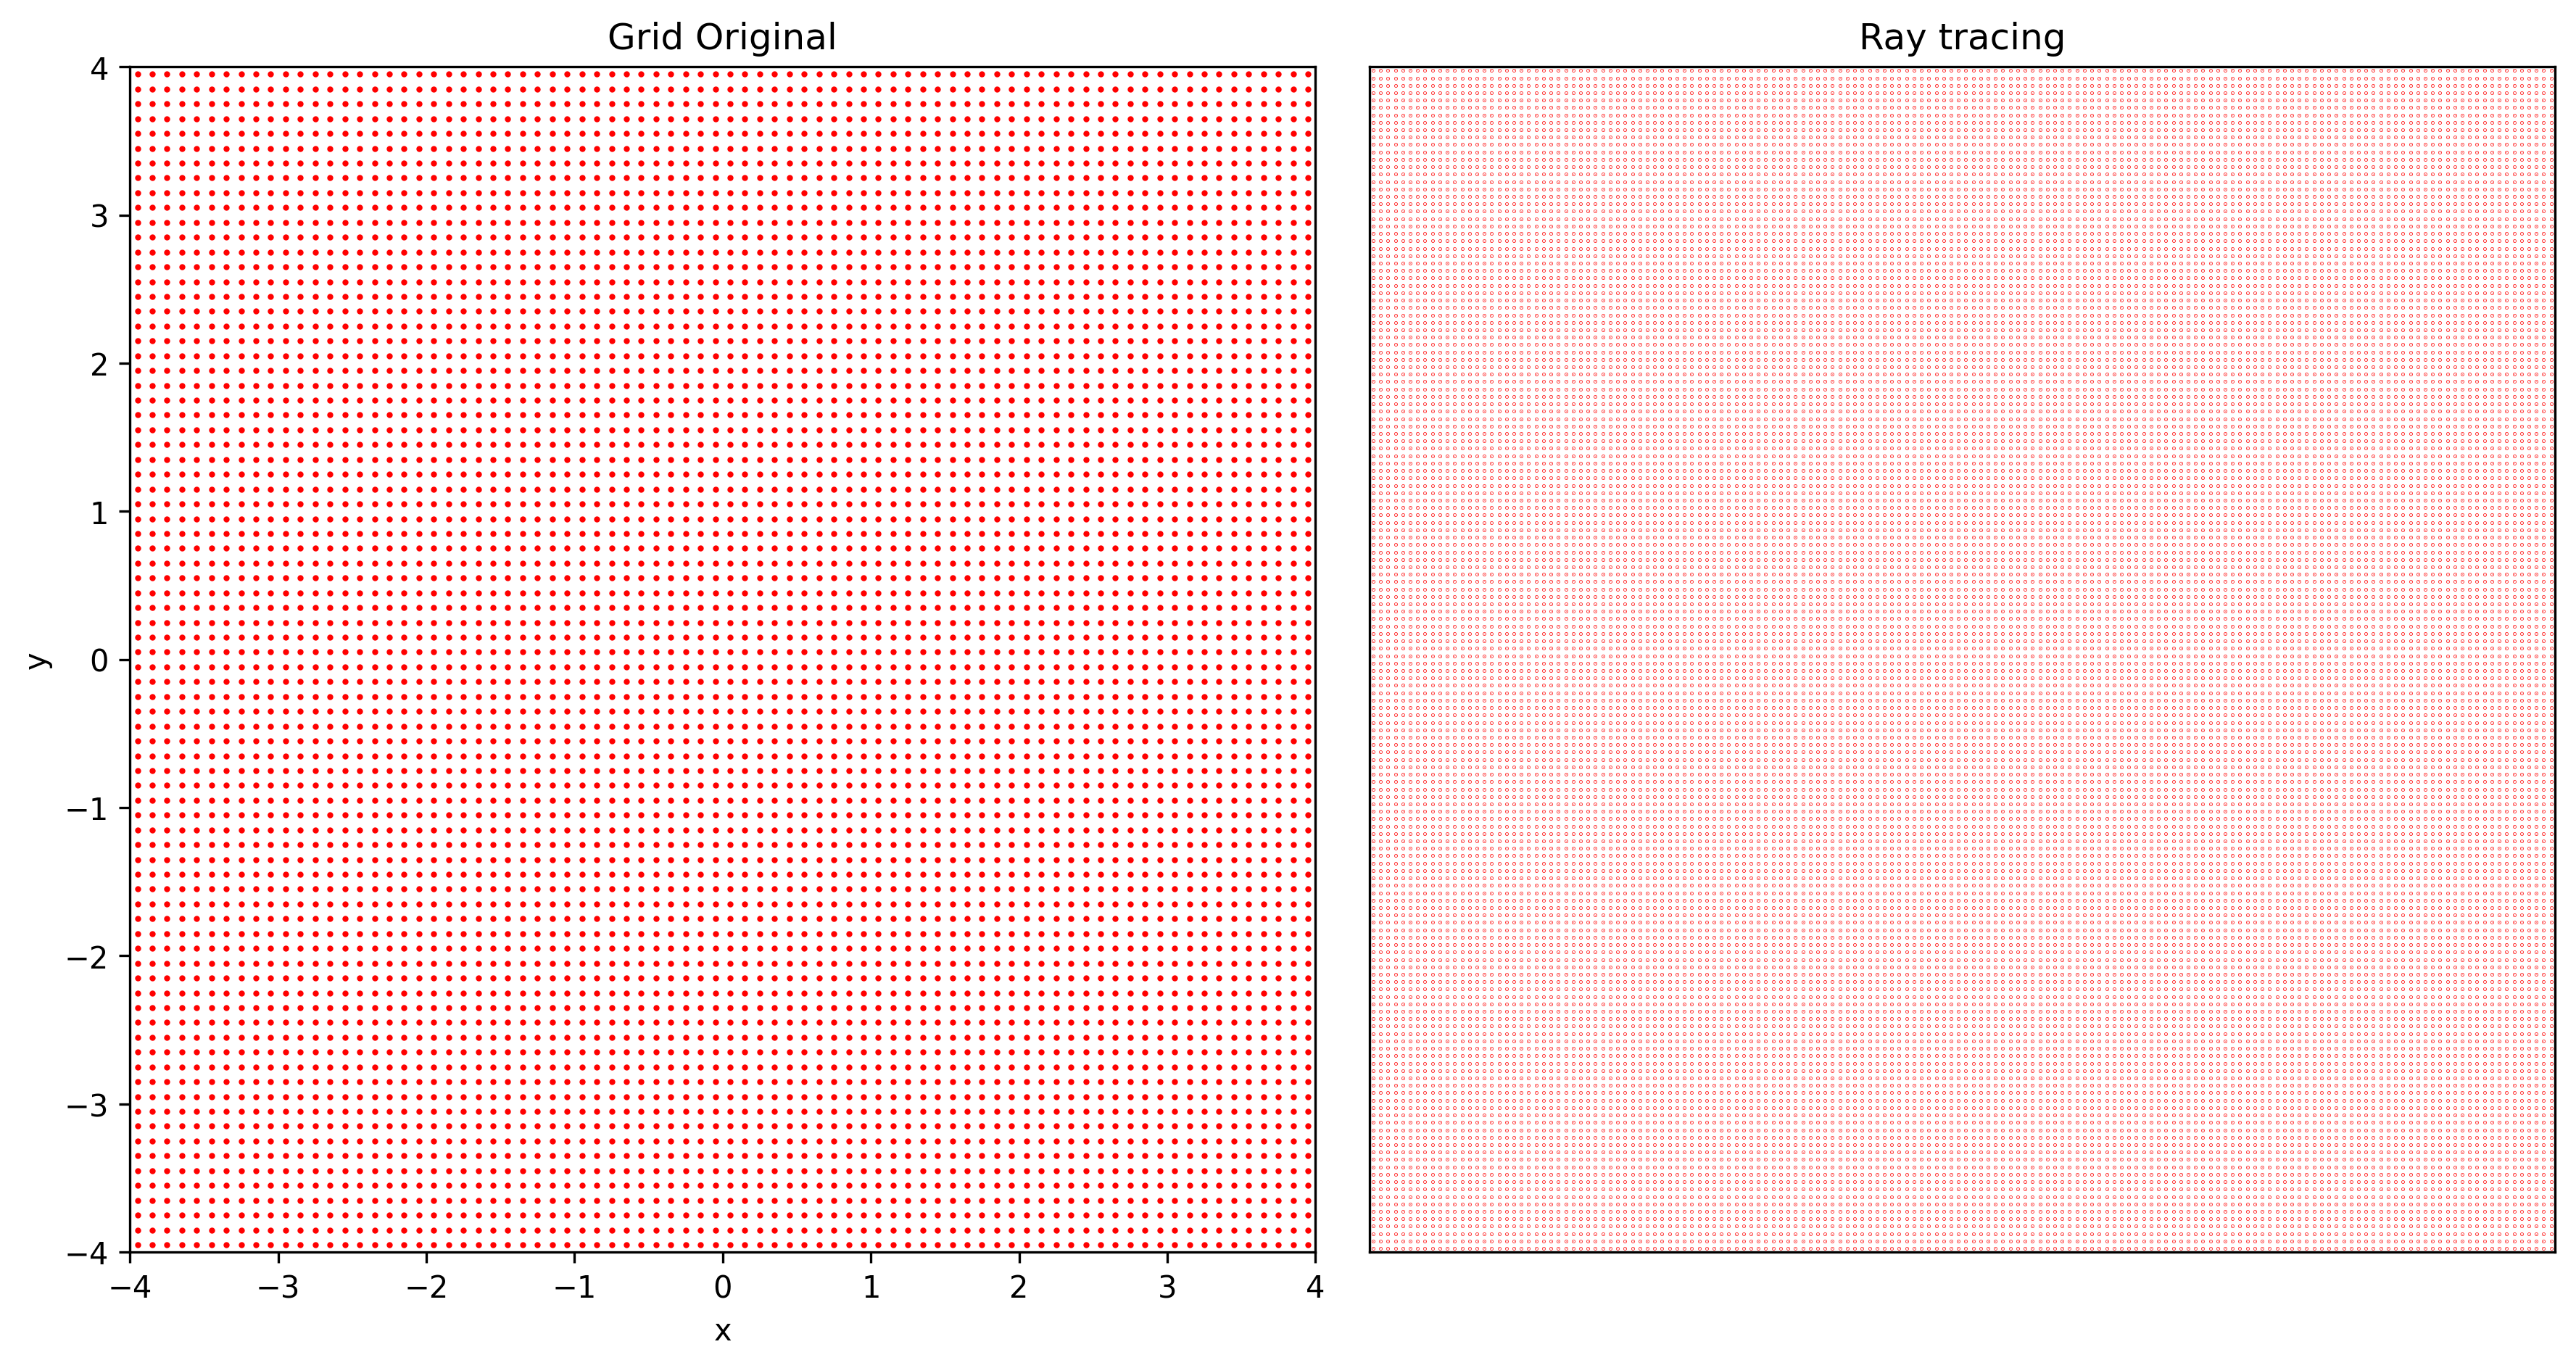

In [3]:
# compute ray-tracing grid

grid_scale = size_s/2 # ten times the source size resolution
grid_width = theta_E_1*4
numpix = int(grid_width / grid_scale)
#numpix=700
#Creamos unos puntos en en el plano fuente#
xx,yy = util.make_grid(numpix, deltapix=0.1) #0.1

#definimos el redshift del plano fuente y plano lente
z_source=1.5
z_lente=0.5


#Consideramos una lente puntual
d=5

lens_model_list=['POINT_MASS','POINT_MASS']
lens=LensModel(lens_model_list)
lensext=LensModelExtensions(lens)
pointmass1_params={'theta_E':theta_E_1,'center_x':d, 'center_y':0} #thetaE en arcosegundos 0.00010090910723578977#
pointmass2_params={'theta_E':theta_E_2,'center_x':0, 'center_y':0}  
kwargs=[pointmass1_params,pointmass2_params]

#Ray-tracing a la fuente: rayshooting
xs,ys=lens.ray_shooting(x=xx,y=yy,kwargs=kwargs)

# ploteamos
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(xx, yy, s=1, color='red')
ax[0].set_title('Grid Original')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_xlim(-4, 4)
ax[0].set_ylim(-4, 4)
ax[0].set_aspect('equal', 'box')

ax[1].scatter(xs, ys, s=0.03, color='red')
ax[1].set_title('Ray tracing')
#ax[1].set_xlabel('x')
#ax[1].set_ylabel('y')
ax[1].set_xlim(-8, 8)
ax[1].set_ylim(-8, 8)
ax[1].set_aspect('equal', 'box')
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])

plt.tight_layout()
plt.rcParams.update({'font.size': 12})
plt.savefig('raytracing1.jpg')
plt.show()


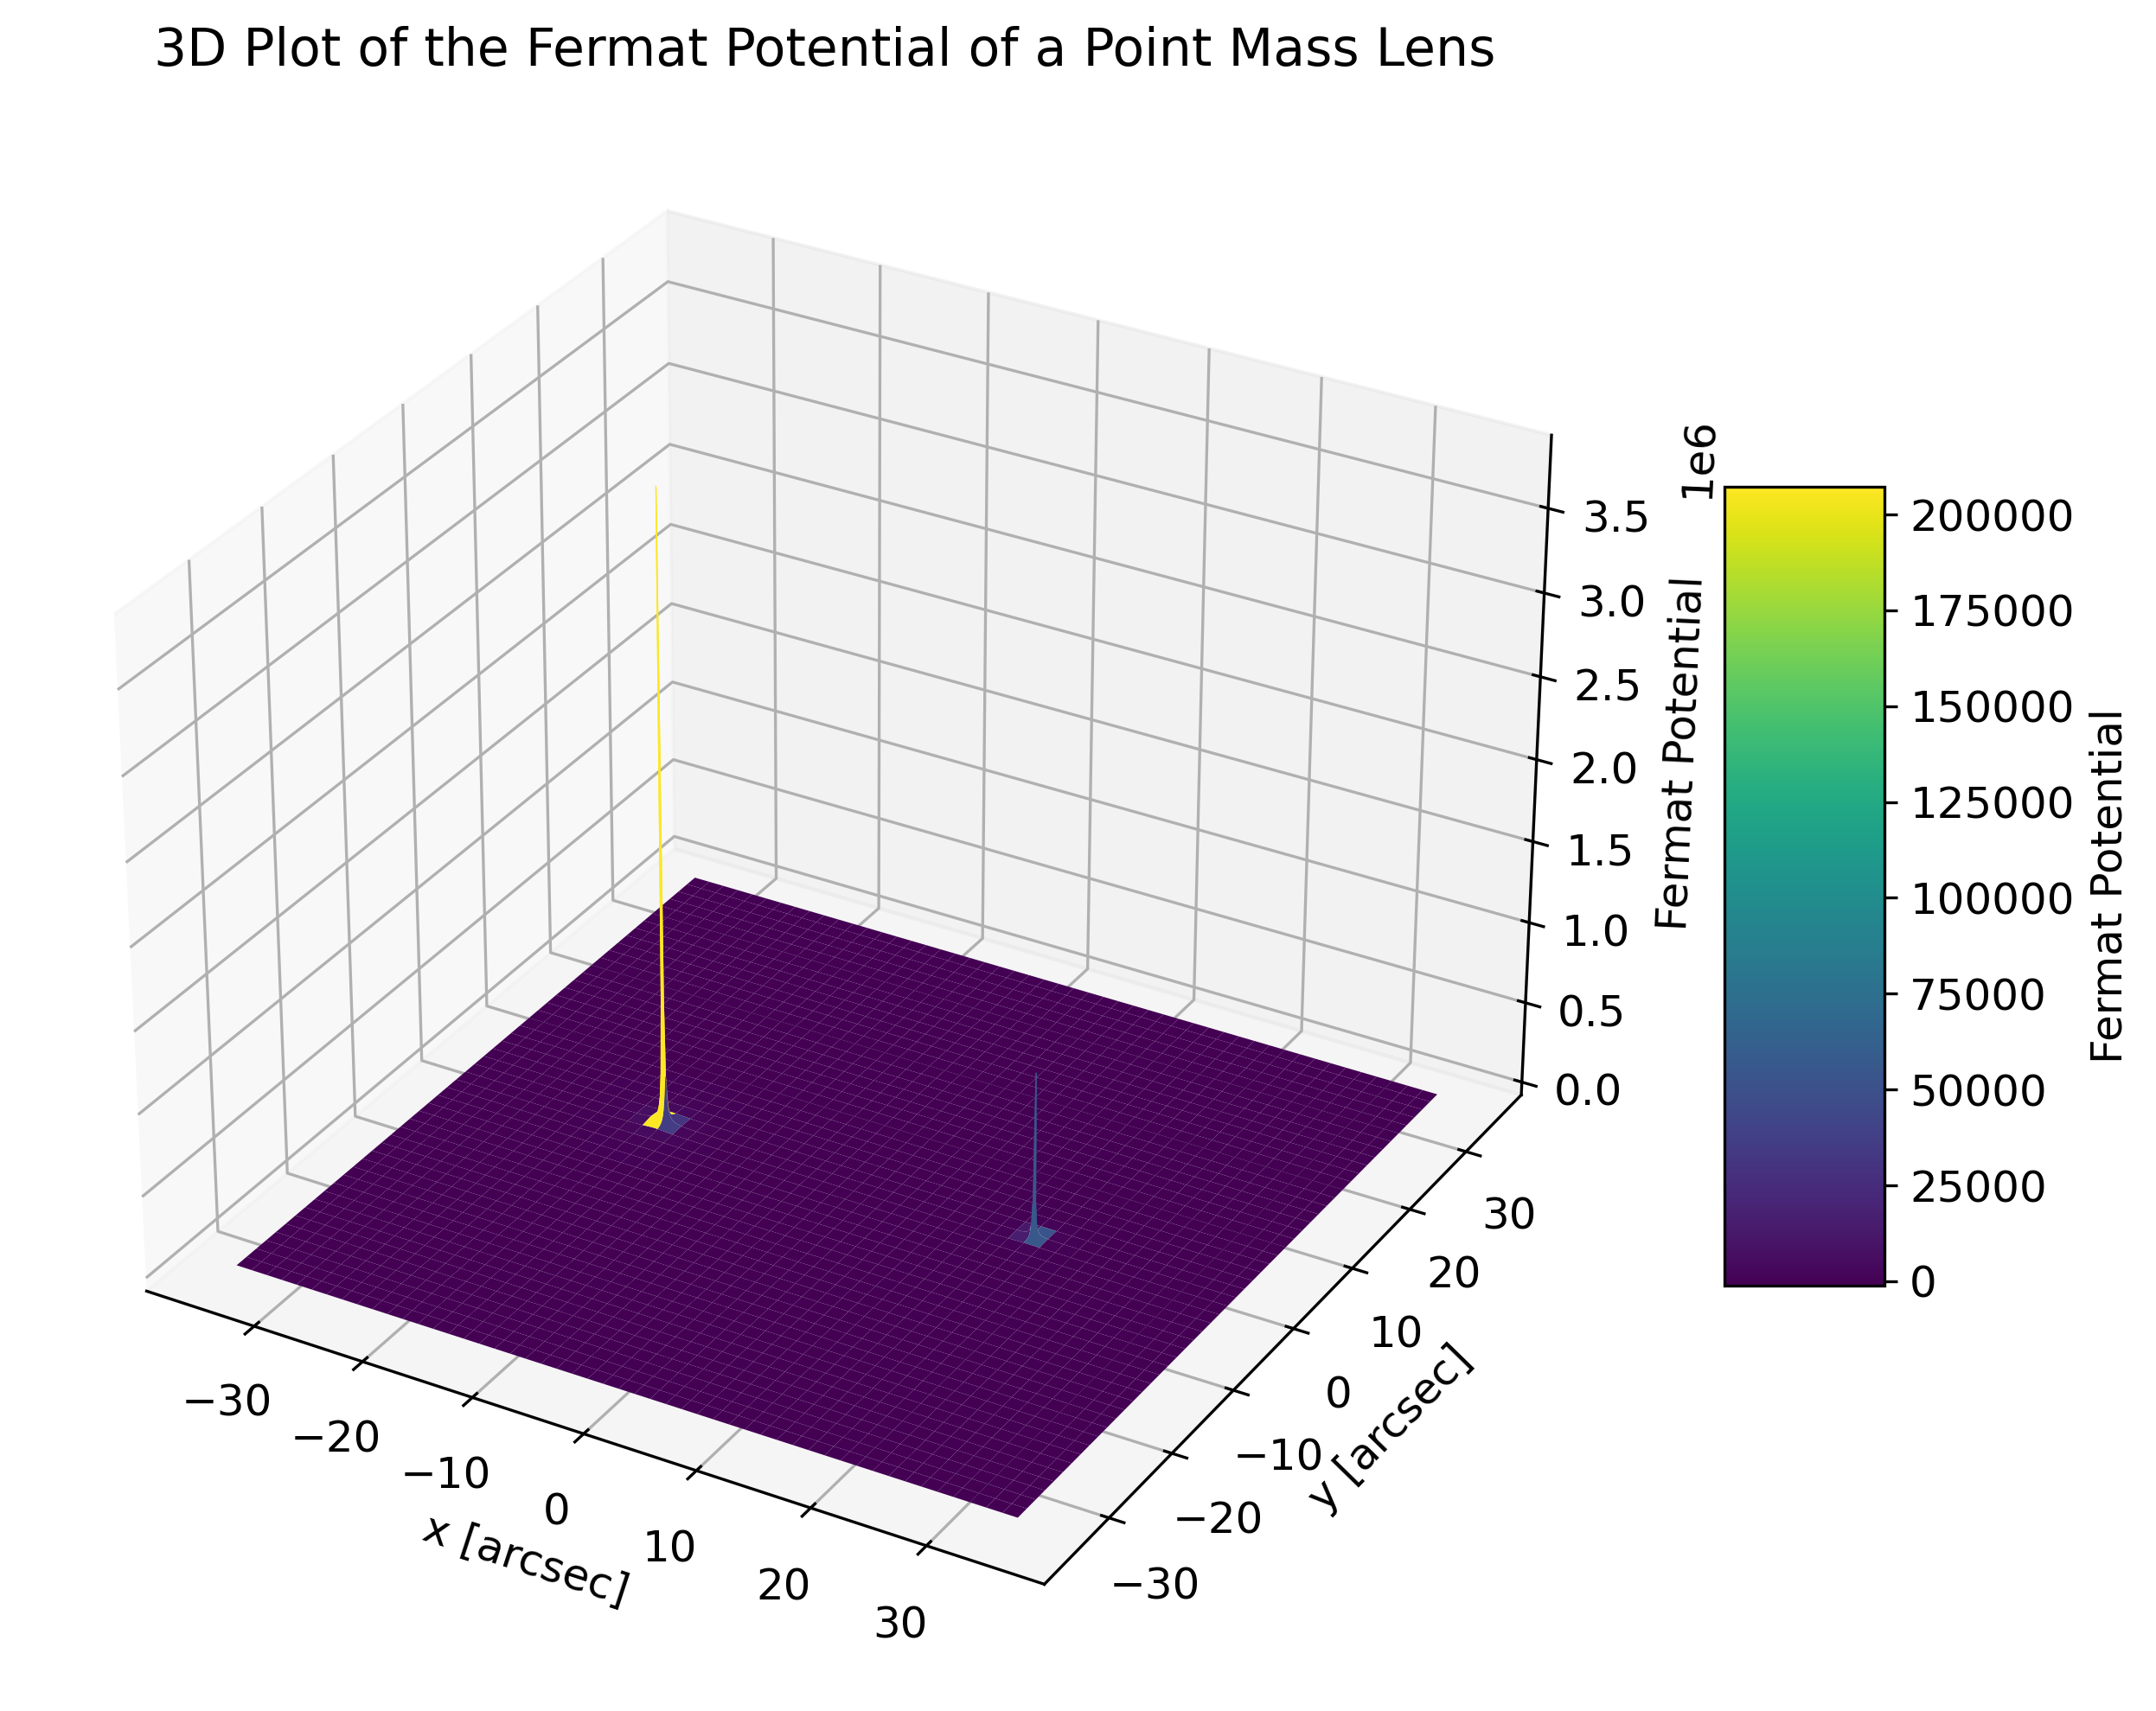

In [121]:
#Potencial de fermat
fermat=lens.fermat_potential(x_image=xx, y_image=yy, kwargs_lens=kwargs, x_source=None, y_source=None)
Phi = fermat.reshape((numpix, numpix))
xxgr=xx.reshape((numpix,numpix))
yygr=yy.reshape((numpix,numpix))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#Ploteamos la superficie
surf = ax.plot_surface(xxgr, yygr, Phi, cmap='viridis', edgecolor='none')

# metemos la barra de color
fig.colorbar(surf, shrink=0.5, aspect=5, label
             ='Fermat Potential')

ax.set_xlabel('x [arcsec]')
ax.set_ylabel('y [arcsec]')
ax.set_zlabel('Fermat Potential')
ax.set_title('3D Plot of the Fermat Potential of a Point Mass Lens')

plt.show()


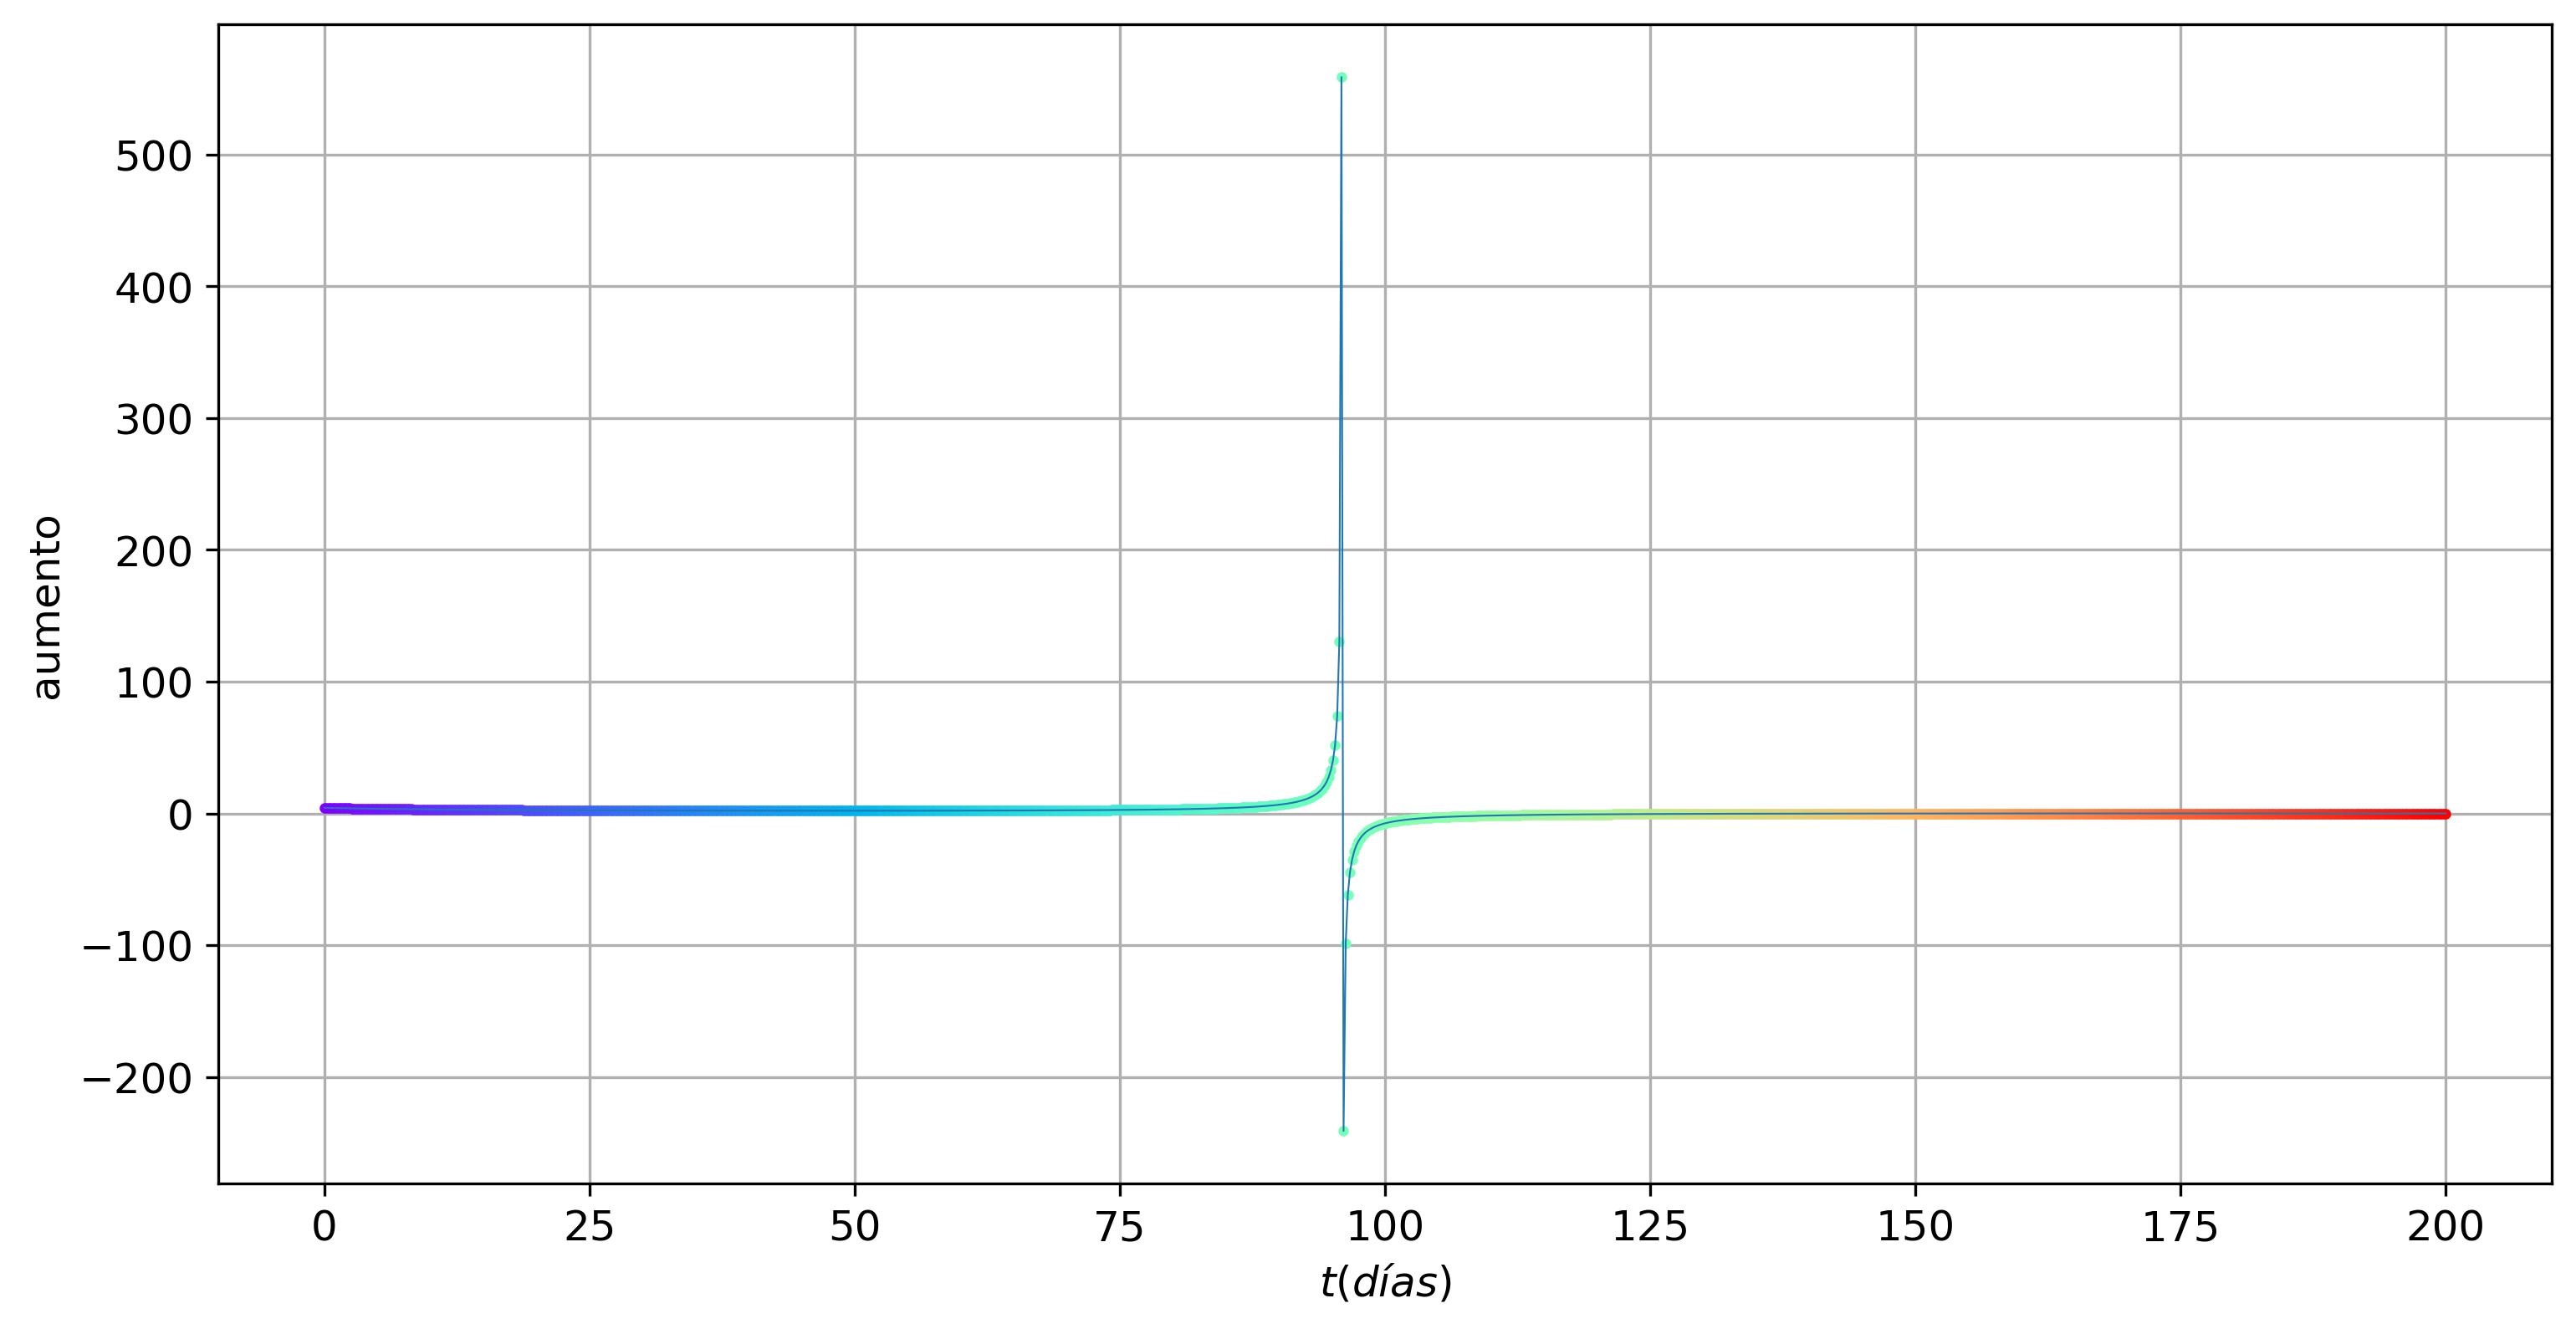

In [132]:
#Modelo de estrella pasando lightcurve#
t0=70
tE=10
theta=-np.pi*0.5/4
y0=7
def SourcePos(t):
    p=(t-t0)/tE
    xsource=np.cos(theta)*p-np.sin(theta)*y0
    ysource=np.sin(theta)*p+np.cos(theta)*y0
    return(xsource,ysource)
t=np.linspace(0,200,1000)
lightcurve=[]
xc=[]
yc=[]
for i in range(len(t)):
    xcord=SourcePos(t[i])[0]
    ycord=SourcePos(t[i])[1]
    xc.append(xcord)
    yc.append(ycord)
    ycord=SourcePos(t[i])[1]
    magt=lens.magnification(xcord,ycord,kwargs)
    lightcurve.append(magt)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

#ax.scatter(t,lightcurve, s=1, color='red')
plt.xlabel(r'$t (días)$')
plt.ylabel(r'aumento')
plt.grid(True)
plt.rcParams.update({'font.size': 12})
color=iter(cm.rainbow(np.linspace(0,1,len(t))))
for i in range(len(t)):
    c=next(color)
    ax.plot(t[i],lightcurve[i],'.',markersize=4,c=c) 
plt.plot(t,lightcurve,linewidth=0.5)
plt.show()

plt.savefig('curvluz1.jpg')

119.43694284918459


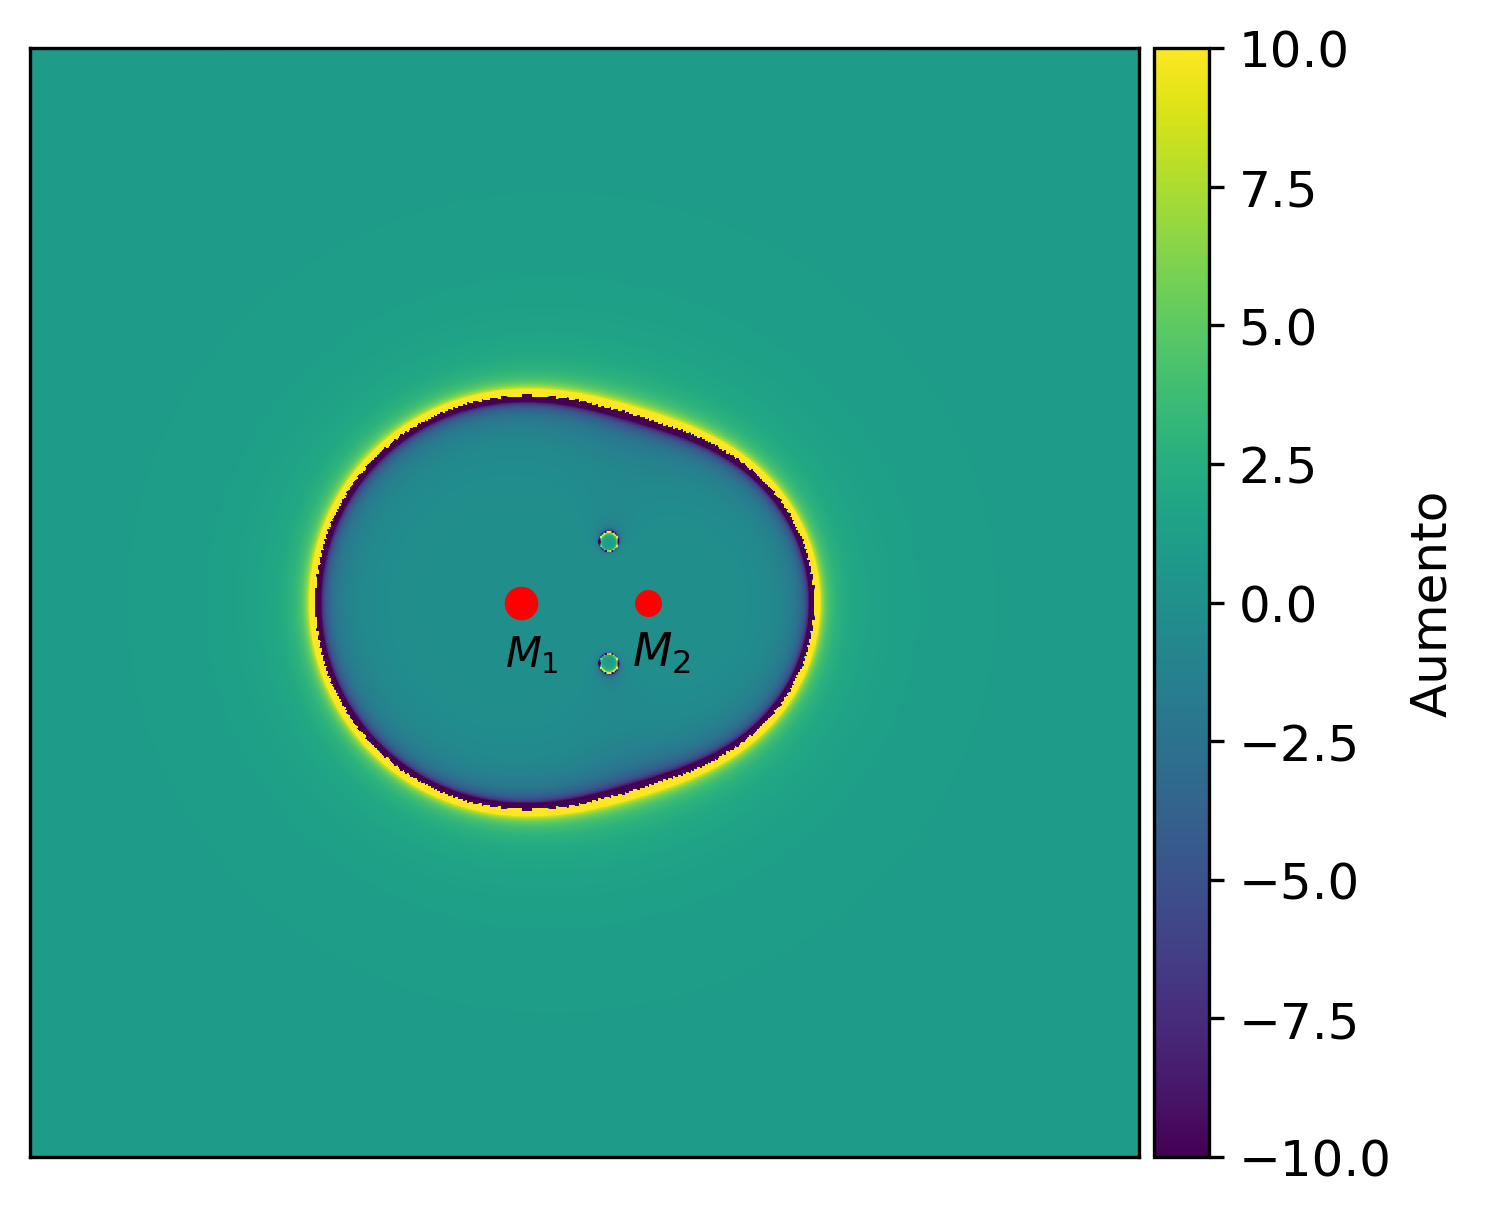

In [152]:
#Mapa aumento#
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
mag=lens.magnification(xx,yy,kwargs)
mag2d = util.array2image(mag)
f, ax = plt.subplots(1, 1, sharex=False, sharey=False)

from lenstronomy.LightModel.light_model import LightModel
ligth = LightModel(light_model_list=['ELLIPSOID'])
kwargs_light = [{'amp': 1, 'radius': 3, 'e1': 0, 'e2': 0, 'center_x': SourcePos(220)[0], 'center_y':SourcePos(300)[1]}]
surface_brightness = ligth.surface_brightness(xs, ys, kwargs_light)
print(np.sum(surface_brightness))

image = util.array2image(surface_brightness)
im = ax.imshow(mag2d, extent=[xx.min(), xx.max(), yy.min(), yy.max()],origin='lower', vmin=-10, vmax=10)
ax.autoscale(False) 
plt.scatter([-d/2],[0],s=50,c='red')
plt.scatter([d/2],[0],s=30,c='red')
plt.text(-d/2-1, -4, '$M_1$', fontsize = 10)
plt.text(d/2-1, -4, '$M_2$', fontsize = 11)
divider=make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax,label='Aumento')
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.rcParams.update({'font.size': 10})
plt.savefig('lineacritica2.jpg',dpi=500)
plt.show()


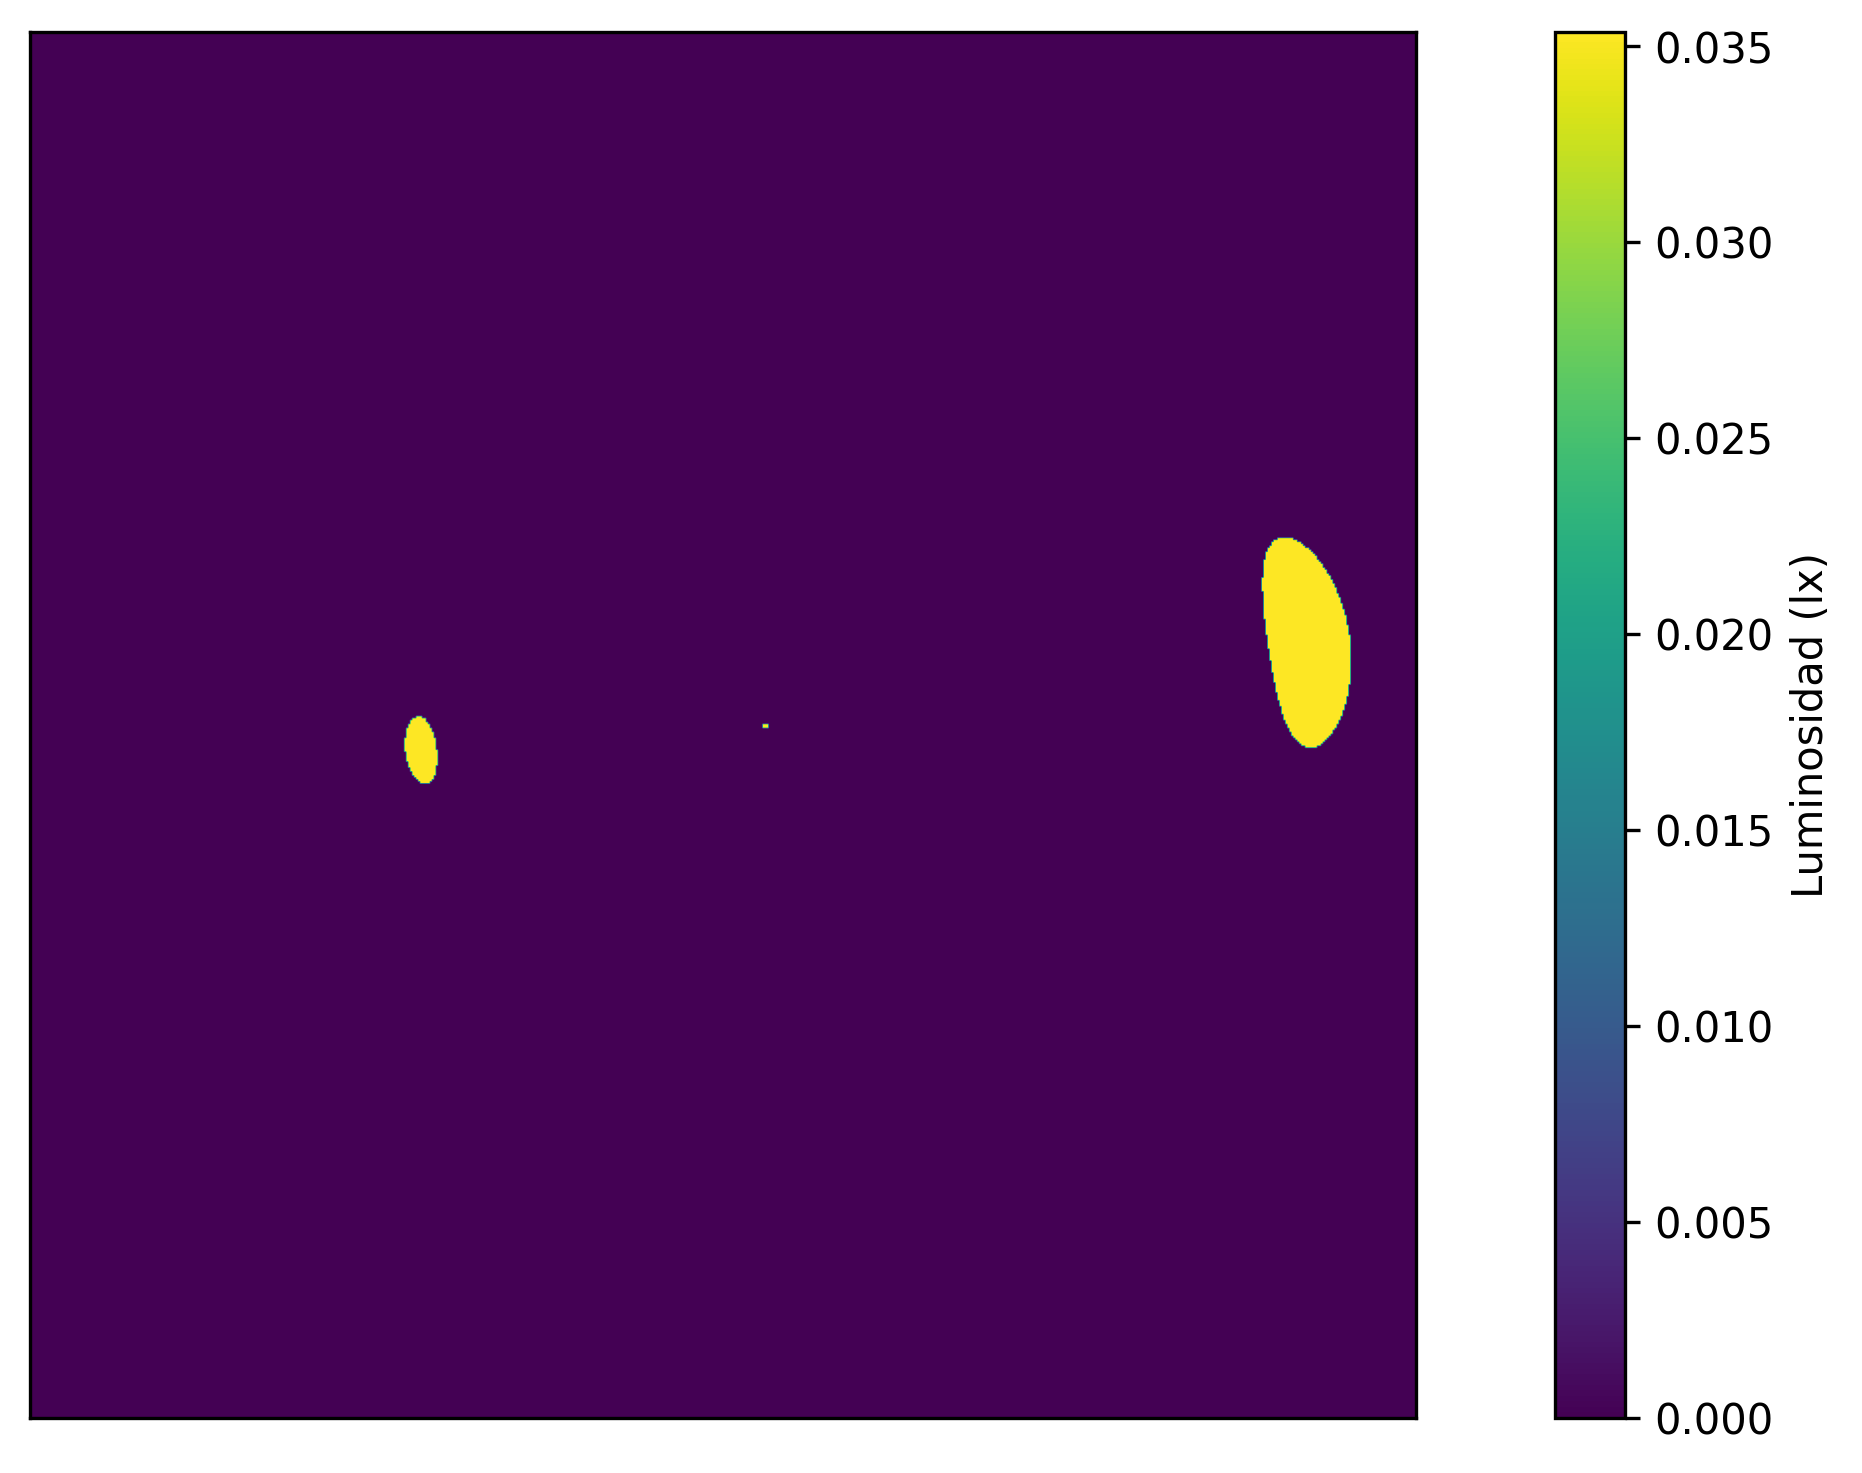

In [68]:
f, ax = plt.subplots(1, 1, figsize=(12, 6), sharex=False, sharey=False)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
plt.imshow(image)
plt.colorbar(label='Luminosidad (lx)')
plt.savefig('imagen1.jpg',dpi=300)
plt.rcParams.update({'font.size': 11})
plt.show()


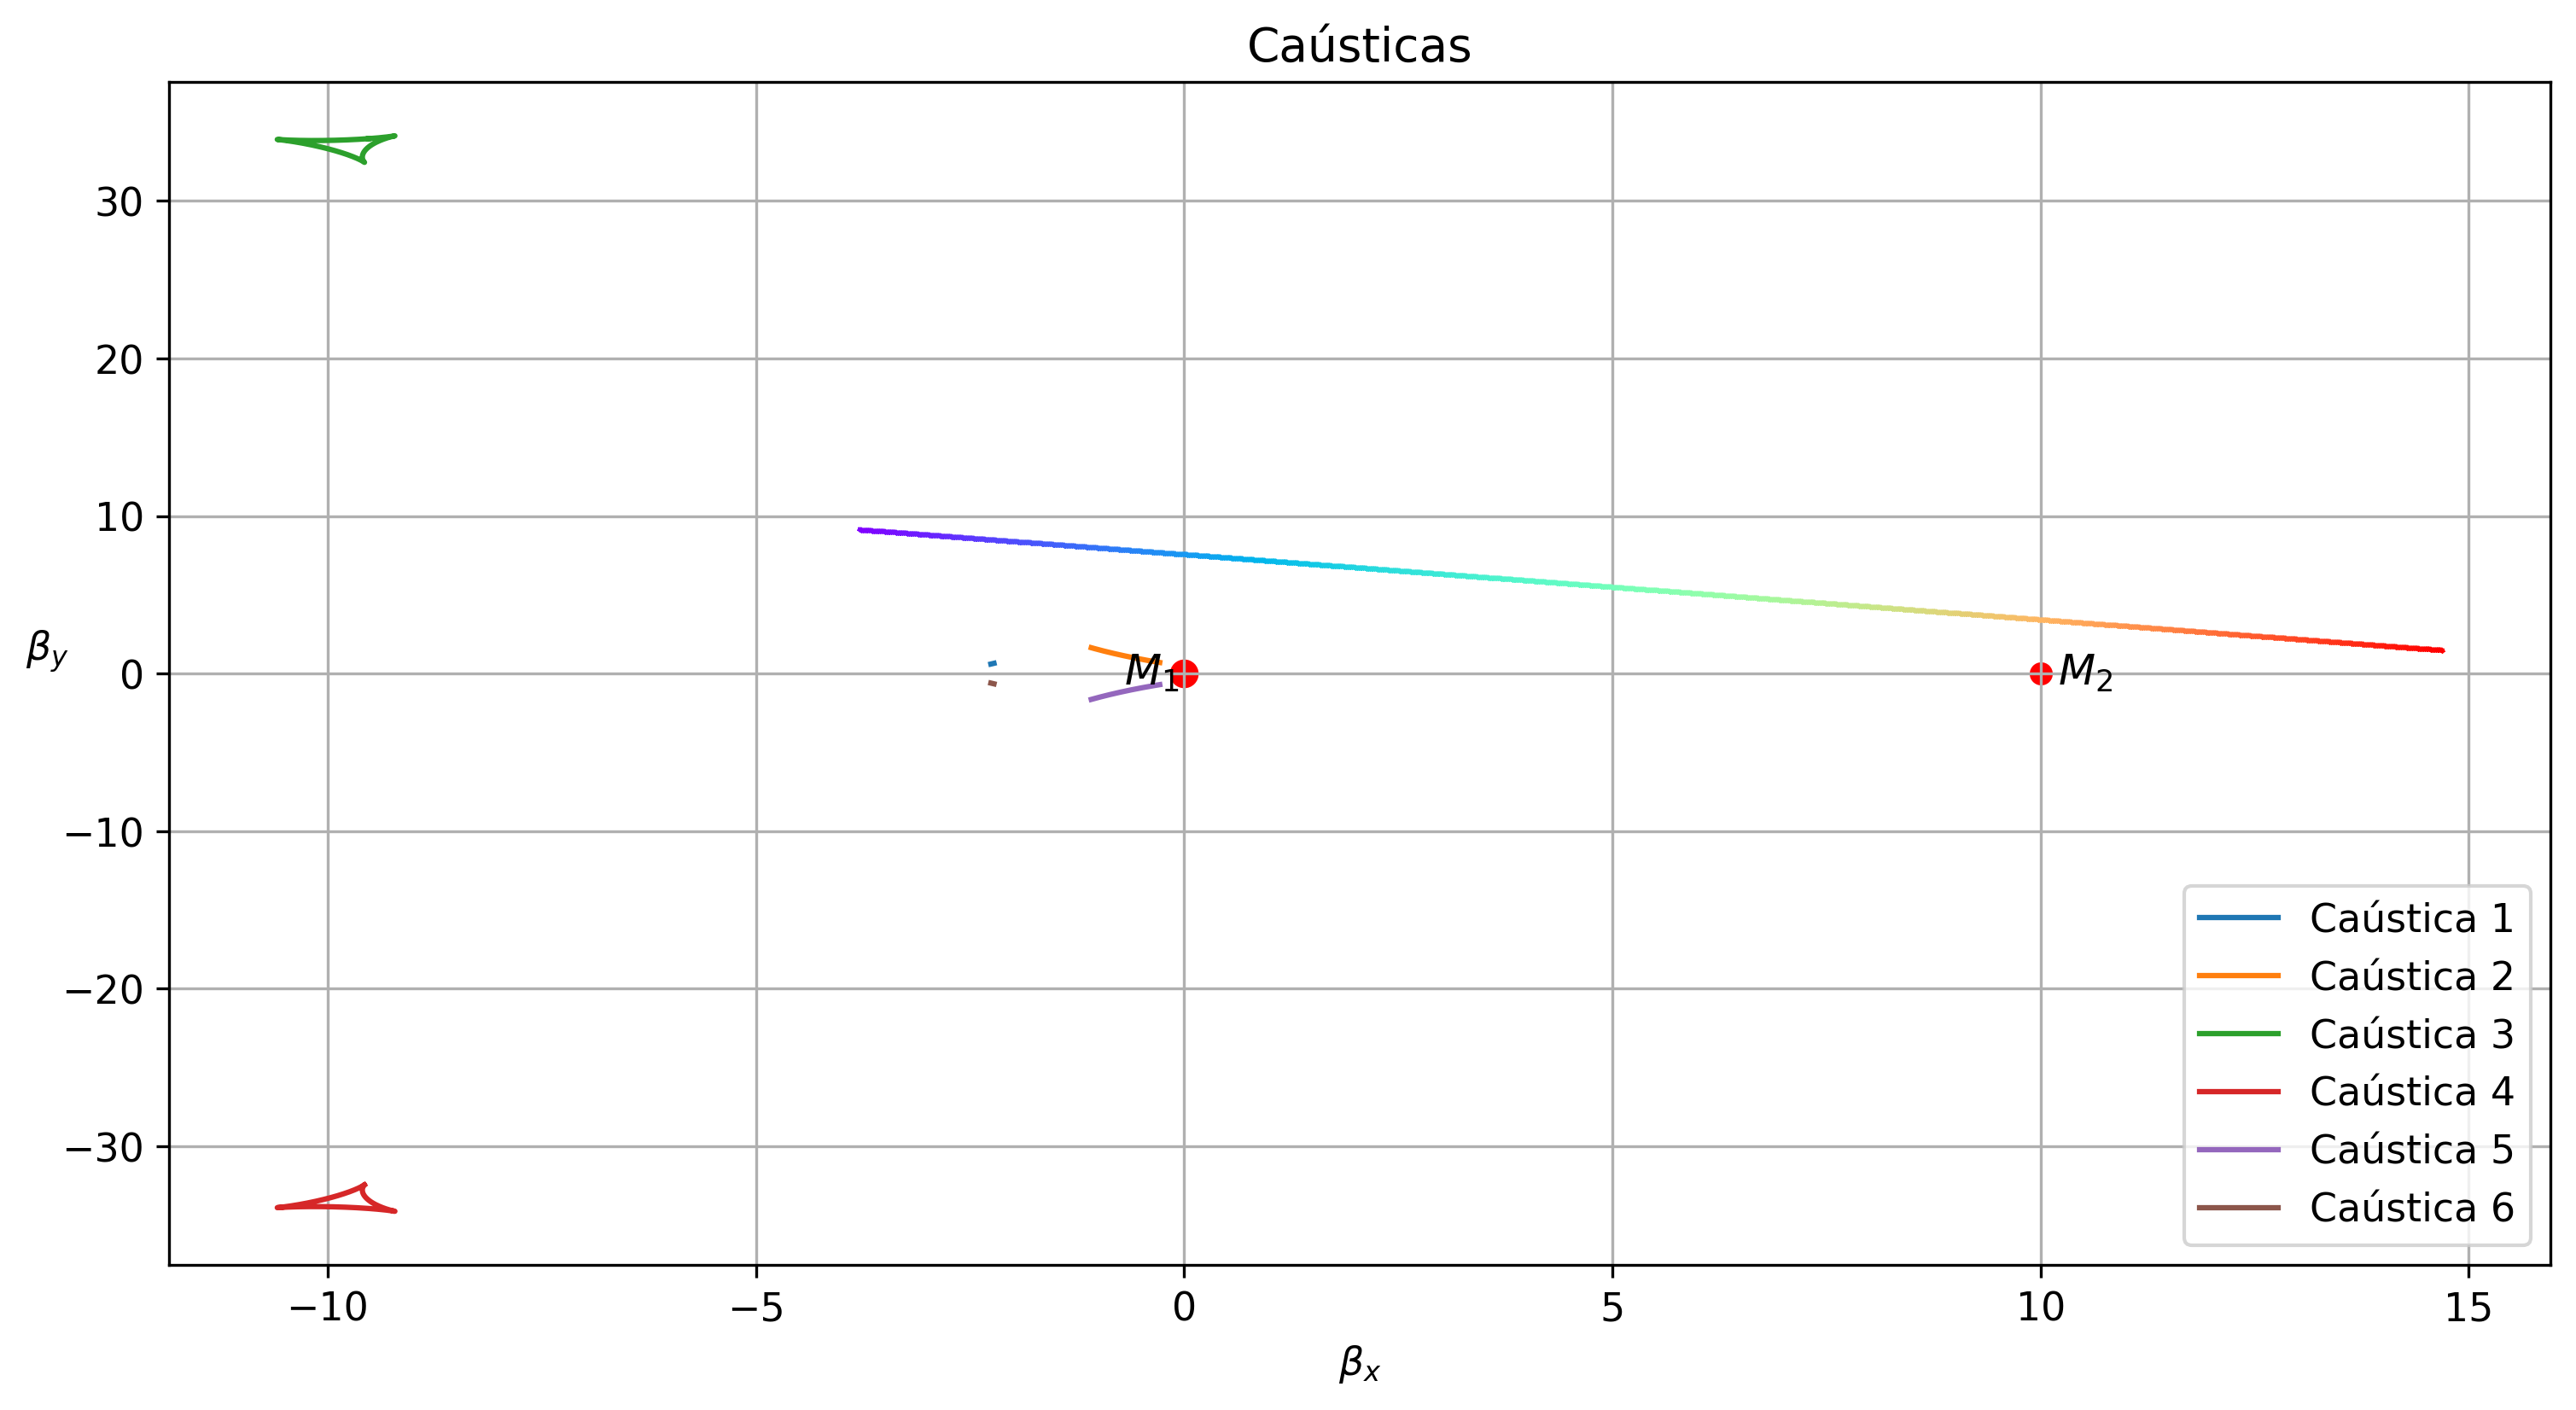

In [69]:
#Causticas y trayectoria de la fuente
criticalra,criticalde,causticsra,causticsd=lensext.critical_curve_caustics(kwargs,compute_window=30)
#Posicion imagenes
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver=LensEquationSolver(lens)
ximl=[]
yiml=[]
def flatten(xss):
    return [x for xs in xss for x in xs]
for i in range(len(xc)):
    x,y=solver.image_position_lenstronomy(xc[i], yc[i], kwargs,search_window=30,num_iter_max=100)
    ximl.append(x)
    yiml.append(y)
    if len(x)==5:
        xbuena=x

#ximl=flatten(ximl)
#yiml=flatten(yiml)

def plot_caustics(x_coords, y_coords):
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    for i in range(len(x_coords)):
        plt.plot(x_coords[i], y_coords[i], label=f'Caústica {i+1}')
    plt.scatter([0],[0],s=50,c='red')
    plt.scatter([d],[0],s=30,c='red')
    plt.text(-0.7, -0.7, '$M_1$', fontsize = 12)
    plt.text(d+0.2, -0.7, '$M_2$', fontsize = 12)
    plt.xlabel(r'$\beta_x$')
    plt.ylabel(r'$\beta_y$',rotation=0)
    plt.title('Caústicas')
    plt.legend(loc='lower right')
    plt.grid(True)
    #plt.plot(xc,yc)
    color=iter(cm.rainbow(np.linspace(0,1,len(xc))))
    for i in range(len(xc)):
        c=next(color)
        ax.plot(xc[i],yc[i],'*',markersize=1,c=c)  #xc o ximl, yc o yiml
    plt.savefig('caustica1.jpg',dpi=500)
    plt.show()

def plot_critica(x_coords, y_coords):
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    for i in range(len(x_coords)):
        plt.plot(x_coords[i], y_coords[i], label=f'Crítica {i+1}')
        
    plt.xlabel(r'$\theta_x$')
    plt.ylabel(r'$\theta_y$',rotation=0)
    #plt.title('Curva crítica')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.scatter([0],[0],s=50,c='red')
    plt.scatter([d],[0],s=30,c='red')
    plt.text(-0.7, -0.7, '$M_1$', fontsize = 12)
    plt.text(d+0.2, -0.7, '$M_2$', fontsize = 12)
    ax.scatter(ximl[194],yiml[194],c='pink')
    ax.set(xlim=[-7.5,15],ylim=[-8,12.5])
    #plt.plot(xc,yc)
    color=iter(cm.rainbow(np.linspace(0,1,len(ximl))))
    #for i in range(len(ximl)):
        #c=next(color)
        #ax.plot(ximl[i],yiml[i],'*',markersize=3,c=c)  #xc o ximl, yc o yiml
    for i in range(len(ximl[194])):
        plt.text(ximl[194][i], yiml[194][i]-1, f'{i+1}', fontsize = 12)
    plt.savefig('critica1.jpg',dpi=500)
    plt.show()

def zoom_plot(x_coords, y_coords, xmin, xmax, ymin, ymax):
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    for i in range(len(x_coords)):
        plt.plot(x_coords[i], y_coords[i], label=f'Caustica {i+1}')

    plt.xlabel(r'$\beta_x$')
    plt.ylabel(r'$\beta_y$',rotation=0)
    #plt.title('Zoom')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.grid(True)
    plt.rcParams.update({'font.size': 11})
    #plt.plot(xc,yc)
    color=iter(cm.rainbow(np.linspace(0,1,len(xc))))
    for i in range(len(xc)):
        c=next(color)
        ax.plot(xc[i],yc[i],'*',markersize=4,c=c)#xc o ximl, yc o yiml
        
    plt.savefig('caustica1zoom.jpg',dpi=500)
    plt.show()
    
plot_caustics(causticsra,causticsd)


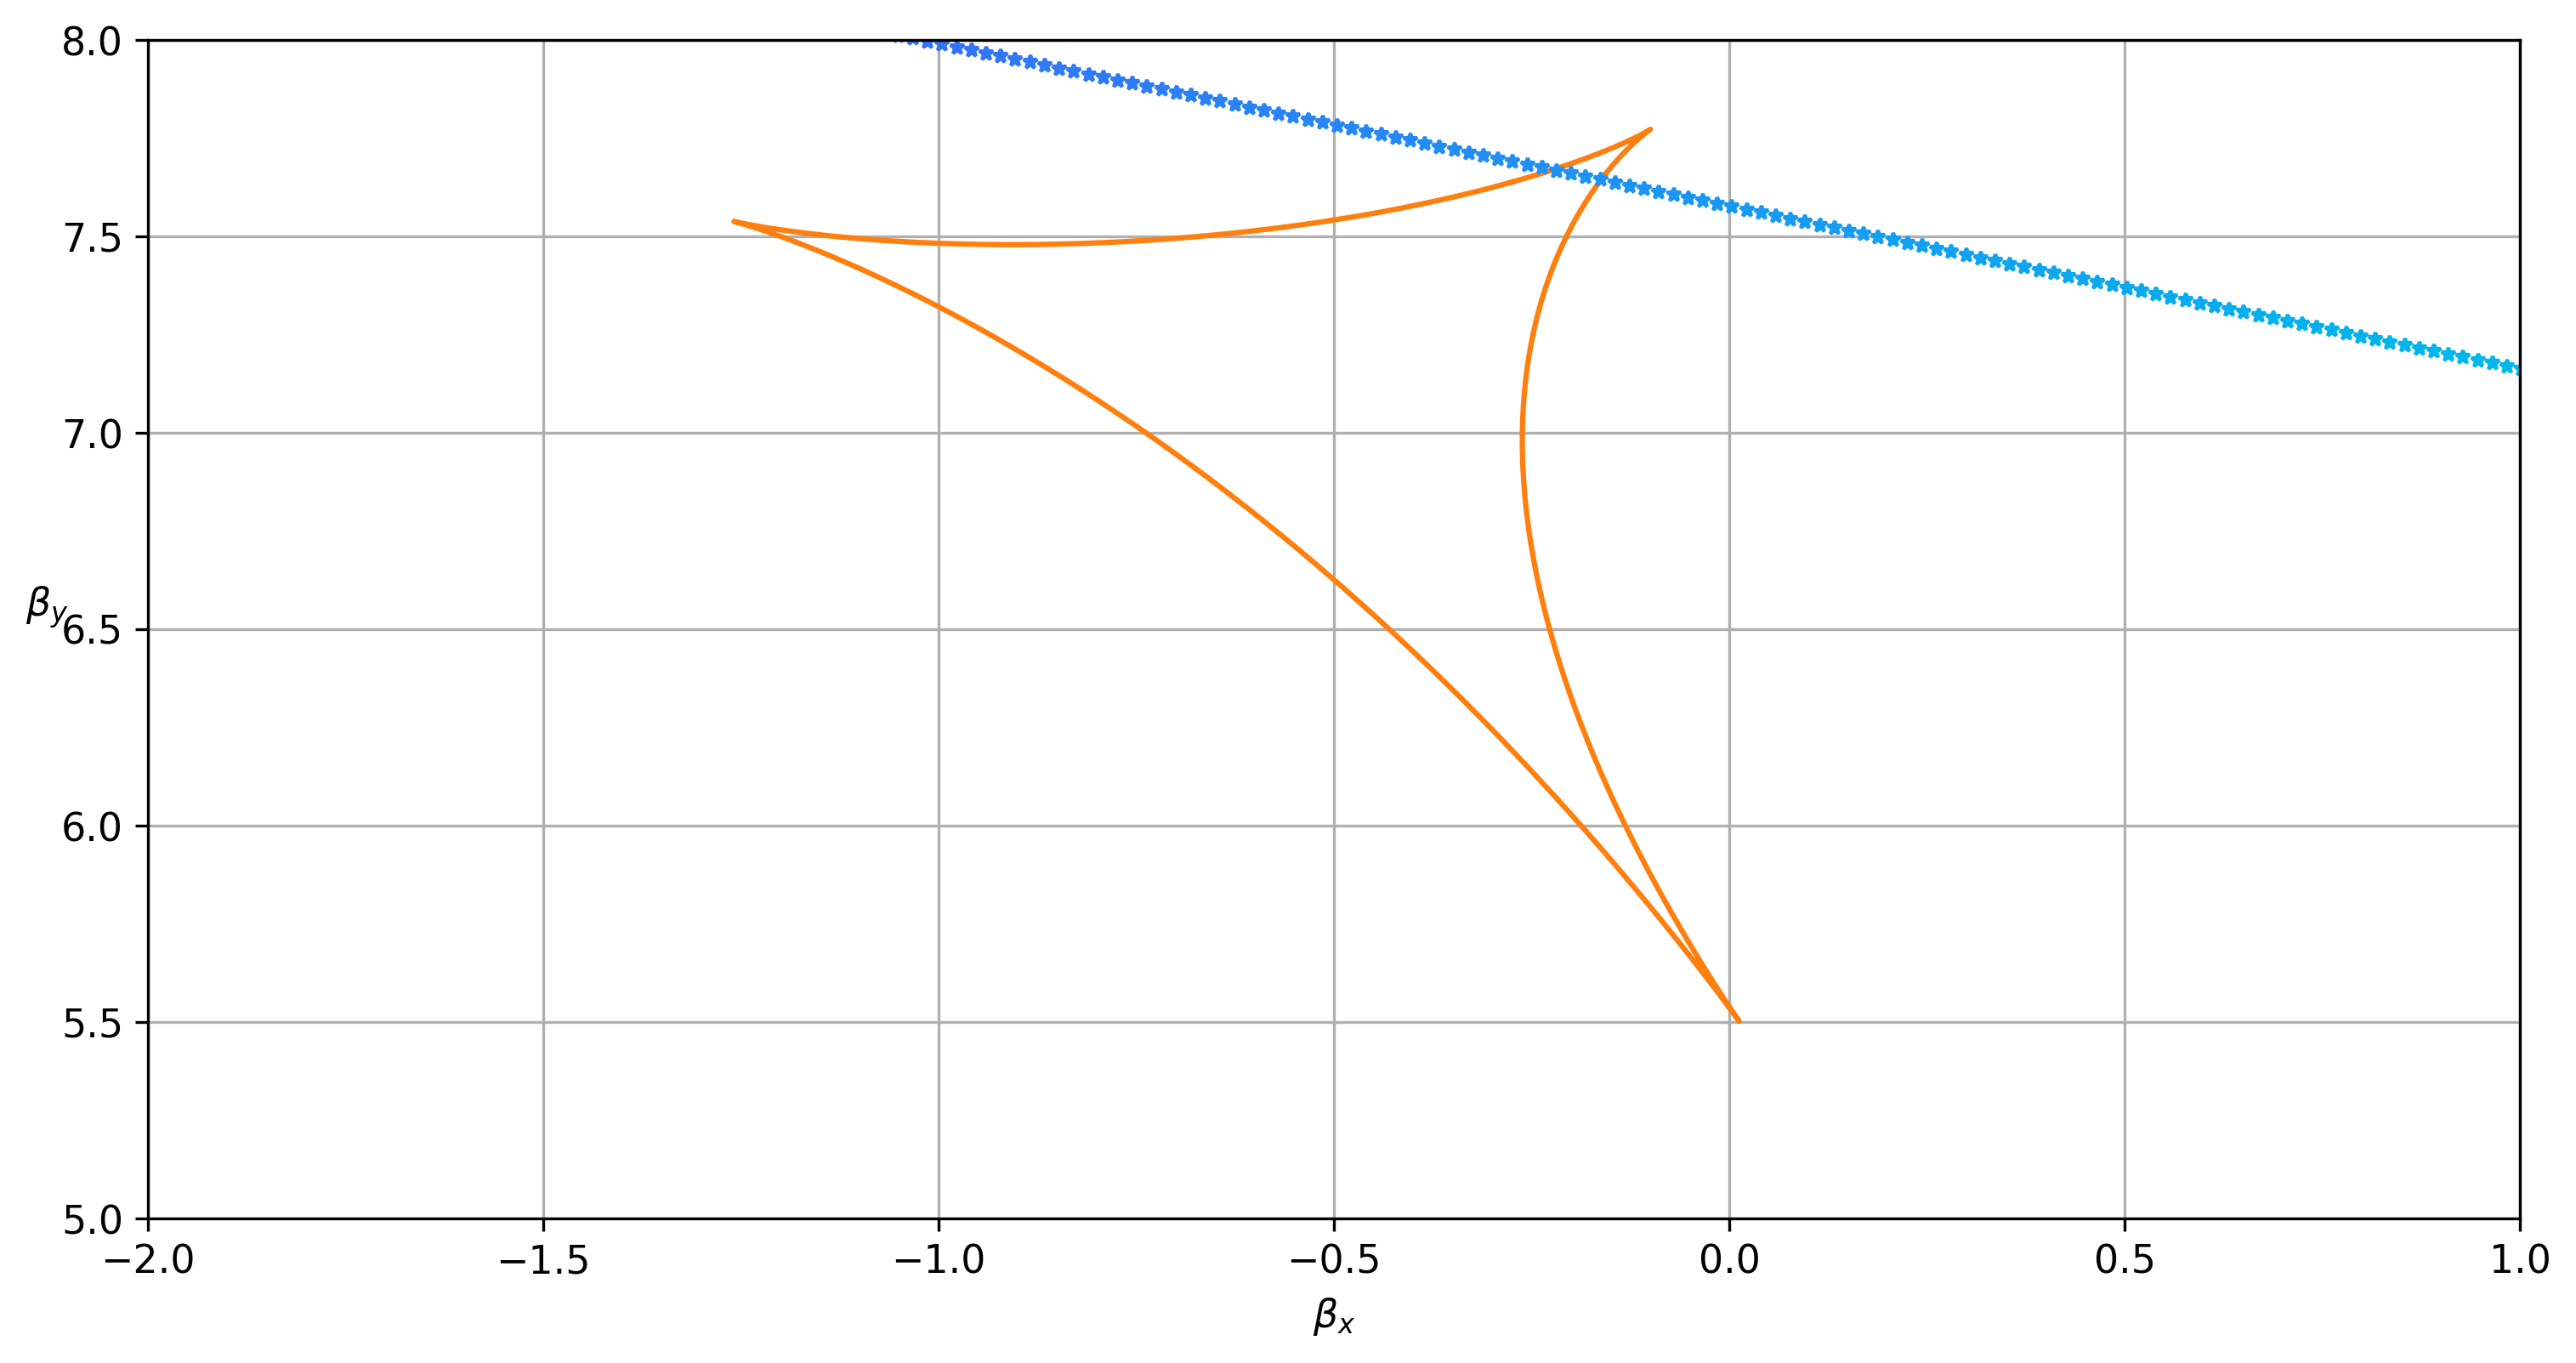

In [18]:
zoom_plot(causticsra,causticsd,-2,1,5,8)

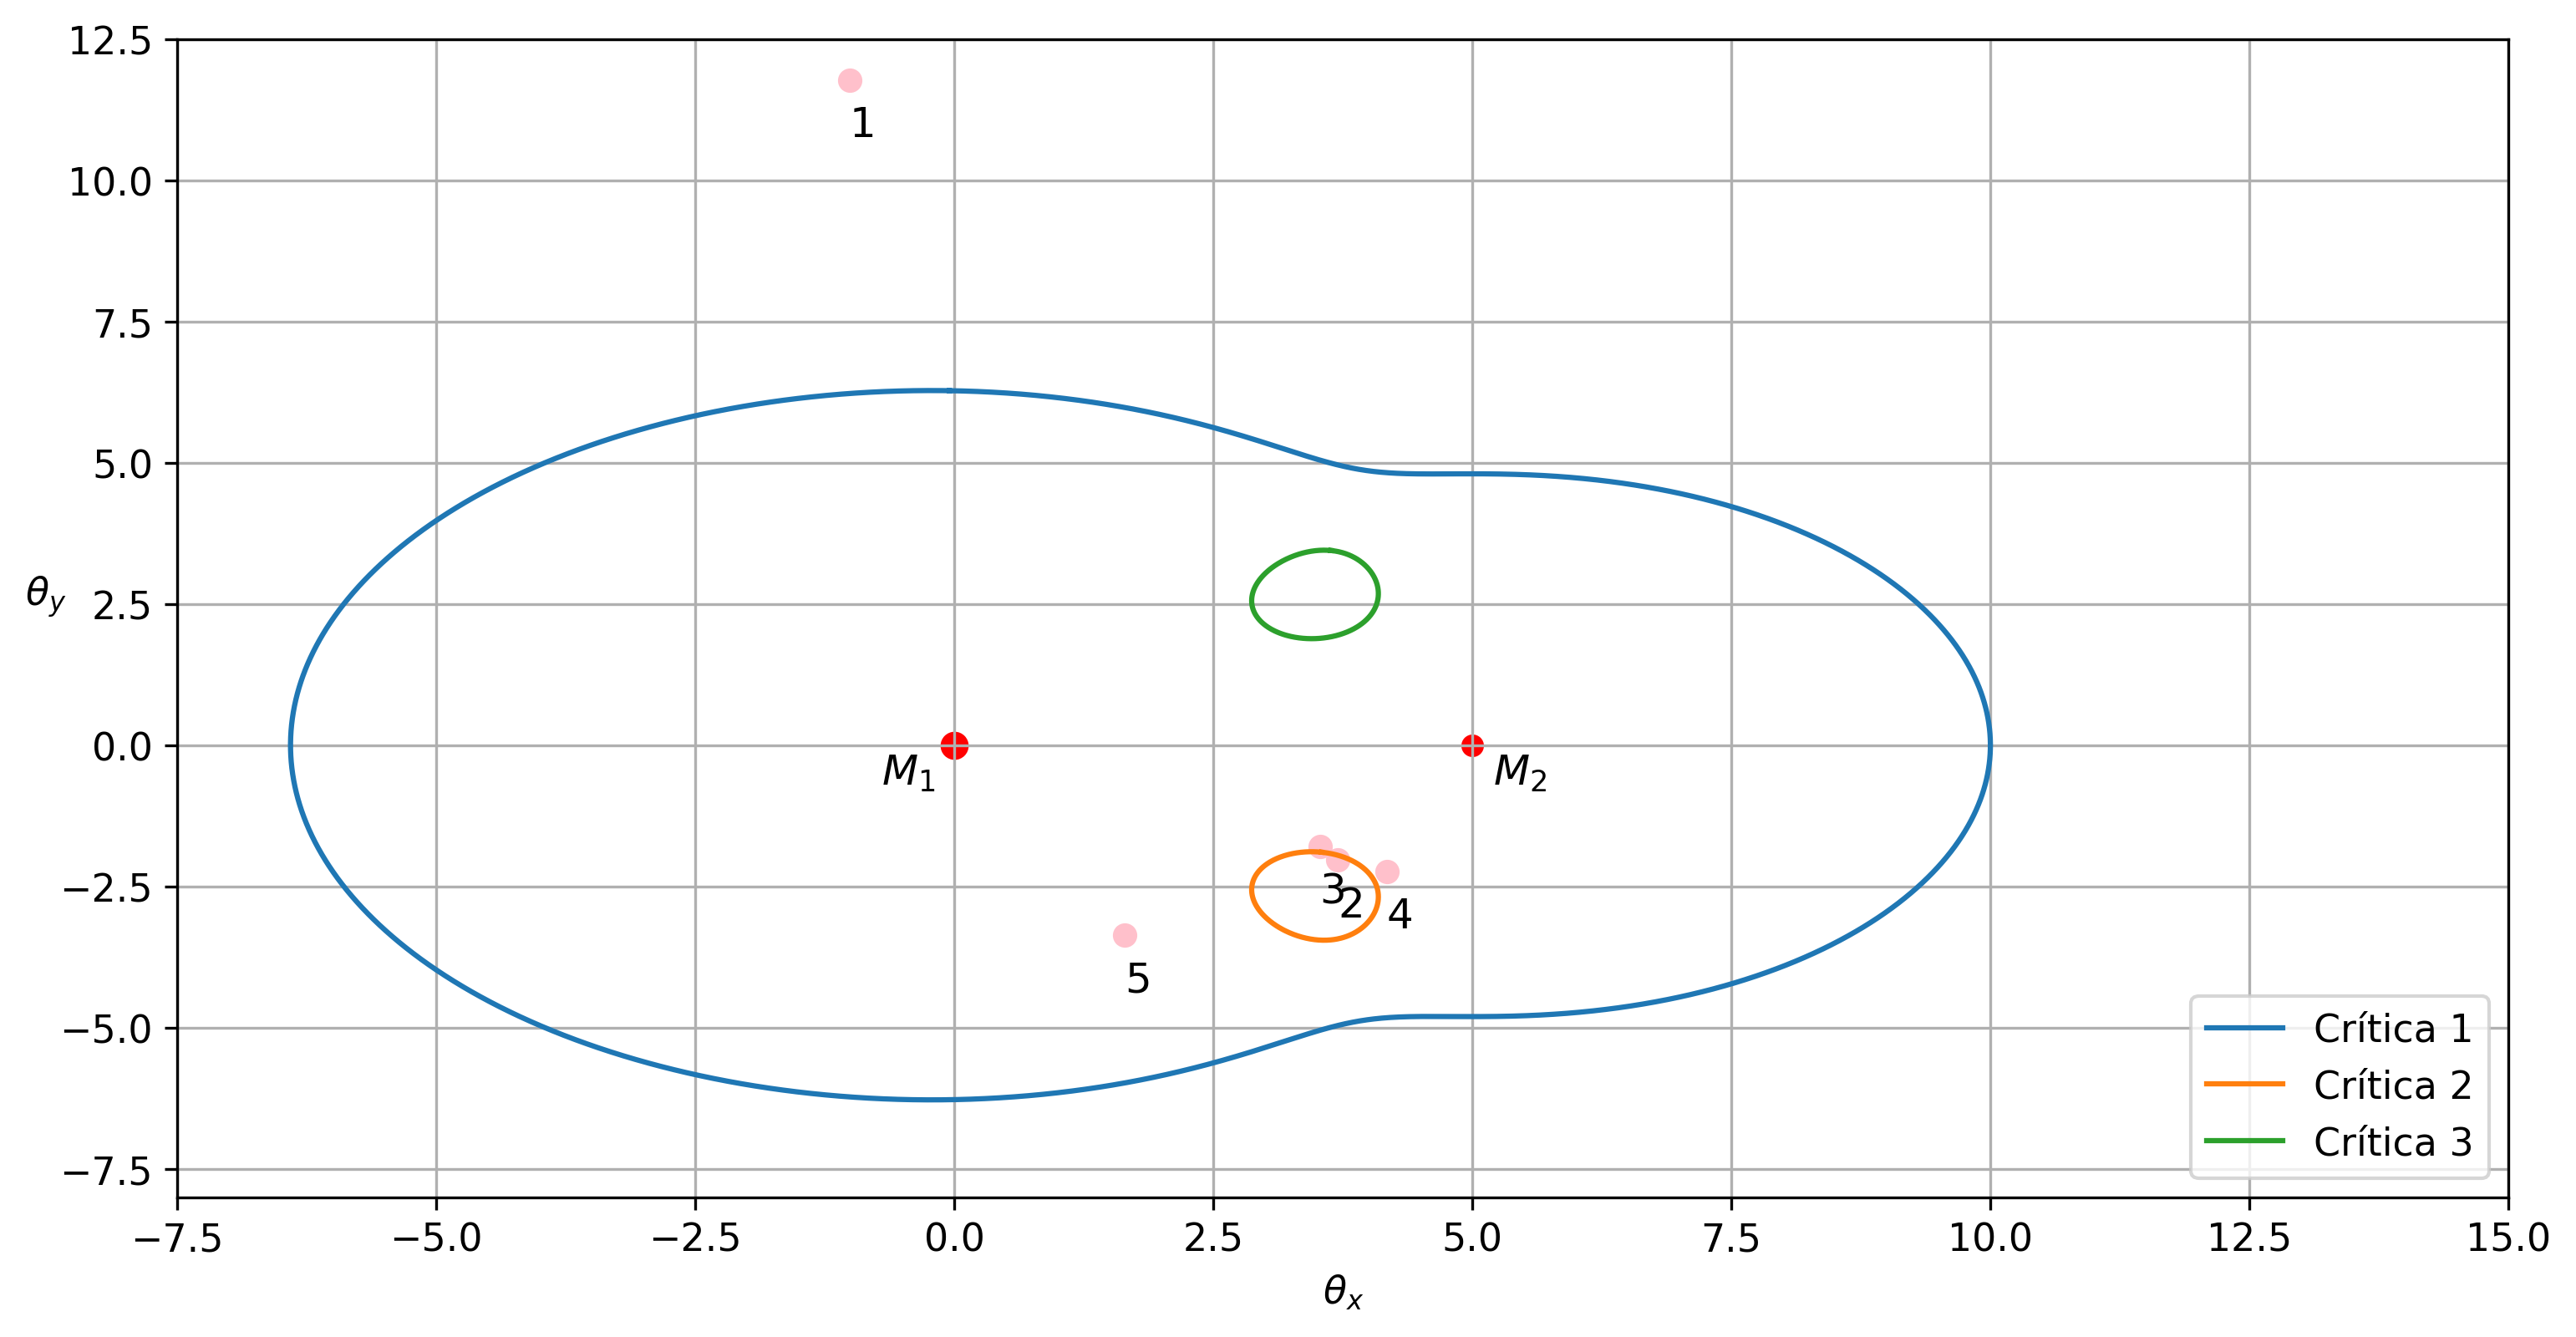

In [20]:
plot_critica(criticalra,criticalde)
    

In [ ]:
plot_caustics()

C:\Users\ikerv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lenstronomy\Plots\lens_plot.py:162: RuntimeWarning: divide by zero encountered in log10
  np.log10(kappa_result),


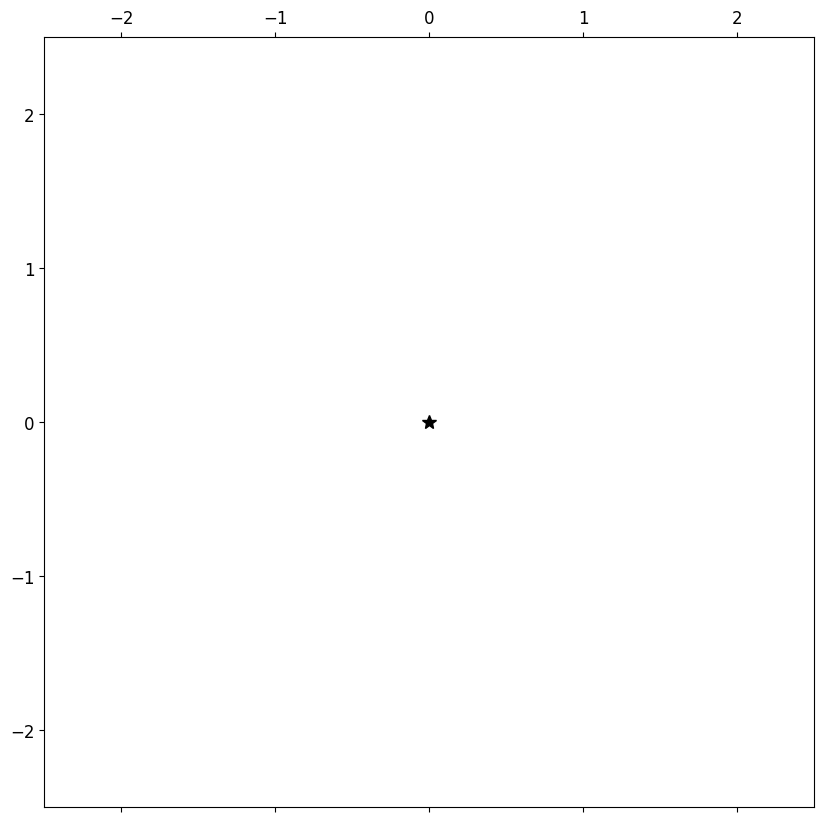

In [185]:
f, axex = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)
lens_plot.lens_model_plot(axex, lensModel=lens, kwargs_lens=kwargs, sourcePos_x=0, sourcePos_y=0, point_source=True, with_caustics=True, fast_caustic=True, coord_inverse=False)
plt.plot(xc,yc)